# CIFAR-10 데이터에 대표적인 CNN 기반 딥러닝 모델을 불러와 적용하기

In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.0+cu118  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
''' 3. Data Augmentation이 적용된 CIFAR10 데이터 다운로드 (Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                  train = True,
                                  download = True,
                                  transform = transforms.Compose([
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

test_dataset = datasets.CIFAR10(root = "../data/CIFAR_10",
                                train = False,
                                transform = transforms.Compose([
                                    # transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:13<00:00, 12953579.10it/s]


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


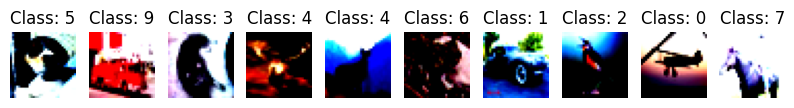

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

- `torchvision.models` 에서 model을 불러오기
  - PyTorch 에서 제공하는 모델 목록 확인
    - https://pytorch.org/vision/stable/models.html
  - `models.resnet34(pretrained = False)`
    - `pretrained = True` : ImageNet 데이터셋으로 미리 학습한 파라미터를 사용할 경우
      - 이 경우, 불러온 파라미터는 ImageNet 데이터셋을 잘 분류할 수 있게 학습되어 있음
    - `pretrained = False` : 모델 구조만 불러올 경우 (특정 initializer에서 랜덤 샘플링한 값을 초기값으로 사용)


In [7]:
''' 6. PyTorch 내에서 제공하는 ResNet34 모델 불러온 후 FC 층 추가 및 Output 크기 설정하기 '''
import torchvision.models as models
model = models.resnet34(pretrained = False)
num_ftrs = model.fc.in_features # resnet34의 Fully connected layer input에 해당하는 노드 수를 num_ftrs 변수에 저장 
model.fc = nn.Linear(num_ftrs, 10) # CIFAR-10 데이터셋의 클래스 갯수 만큼 output을 생성할 수 있도록 Fully connected layer 구성
model = model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
''' 7. Optimizer, Objective Function 설정하기 '''
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
''' 8. 불러온 Resnet34 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))


In [10]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
''' 10. 불러온 ResNet34 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.430506
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.870384
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.756226
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.552680
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.638183
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 1.574306
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.365736
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.028033

[EPOCH: 1], 	Test Loss: 0.0362, 	Test Accuracy: 59.59 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.890665
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.106729
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.986748
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 1.099262
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 1.596026


KeyboardInterrupt: ignored

- `models.resnet34(pretrained = True)` 사용

In [ ]:
''' 11. IMAGENET 데이터로 학습이 된 ResNet34 모델을 불러온 후 Fine Tuning 해보기 '''
model = models.resnet34(pretrained = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))